![image.png](https://i.imgur.com/a3uAqnb.png)

# **Brain MRI Tumor Segmentation** 🧠

In this exercise, you will apply what you learned in the previous lab to build a **brain tumor segmentation model** using a pretrained U-Net.

## **Learning Objectives**
- Build a custom Dataset class for MRI segmentation  
- Use `segmentation_models_pytorch (SMP)` to load **U-Net** with a **pretrained encoder**  
- Train and evaluate the model on brain MRI images

## **Dataset**
We will use the **LGG MRI Segmentation** dataset which contains:
- **Brain MRI scans** (TIFF images)
- **Tumor segmentation masks** (TIFF images)
- Images are organized by patient folders

## **Setup: Download Dataset and Install Dependencies**

Run the following cells to download the dataset and install the required libraries.

In [1]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00


In [2]:
import kagglehub
import os

# Download the LGG MRI Segmentation dataset
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Path to dataset files: /kaggle/input/lgg-mri-segmentation


**Explore the dataset structure**

In [3]:
# List the contents of the dataset folder
dataset_root = os.path.join(path, "lgg-mri-segmentation", "kaggle_3m")

print("Dataset contents:")
print(os.listdir(dataset_root)[:10])  # Show first 10 patient folders

Dataset contents:
['TCGA_DU_7010_19860307', 'TCGA_DU_8162_19961029', 'TCGA_FG_A4MT_20020212', 'TCGA_FG_5964_20010511', 'TCGA_DU_A5TS_19970726', 'TCGA_HT_7692_19960724', 'TCGA_DU_5849_19950405', 'TCGA_FG_A60K_20040224', 'TCGA_HT_7475_19970918', 'TCGA_FG_6691_20020405']


---

## **Task 1: Explore the Dataset Structure**

The dataset is organized by patient folders. Each folder contains:
- MRI images (e.g., `TCGA_CS_4941_19960909_11.tif`)
- Corresponding masks (e.g., `TCGA_CS_4941_19960909_11_mask.tif`)

**Your task:** Write code to:
1. Count the total number of image-mask pairs
2. Store all image paths and mask paths in two lists

In [4]:
image_paths = []
mask_paths = []

# Loop through all patient folders
for patient_folder in os.listdir(dataset_root):
  patient_path = os.path.join(dataset_root, patient_folder)

  if os.path.isdir(patient_path):
    for filename in os.listdir(patient_path):
      # TODO: Check if the file is a mask (contains "_mask")
      # If it's a mask, add to mask_paths
      # Otherwise, if it's a .tif file, add to image_paths

      # YOUR CODE HERE
      if '_mask' in filename:
        mask_paths.append(os.path.join(patient_path, filename))
      elif filename.endswith('.tif'):
        image_paths.append(os.path.join(patient_path, filename))

print(f"Total images: {len(image_paths)}")
print(f"Total masks: {len(mask_paths)}")

Total images: 3929
Total masks: 3929


**Important:** The brain tumor dataset is **highly imbalanced**:
- Many MRI slices have **no tumor at all** (empty masks)
- Even in slices with tumors, the tumor region is typically only ~1-5% of the image

If we train with all samples, the model learns to predict "no tumor" everywhere because that minimizes loss on the majority of pixels.

In [5]:
# Select samples with tumors
import numpy as np
from PIL import Image

samples_with_tumor = []

for img_path, mask_path in zip(image_paths, mask_paths):
  mask = np.array(Image.open(mask_path))
  if np.sum(mask) > 0:  # Has tumor pixels
    samples_with_tumor.append((img_path, mask_path))

In [6]:
image_paths = [s[0] for s in samples_with_tumor]
mask_paths = [s[1] for s in samples_with_tumor]

print(f"Total samples: {len(samples_with_tumor)}")

Total samples: 1373


---

## **Task 2: Create the Dataset Class**

Create a custom PyTorch Dataset class for the MRI segmentation task.

**Requirements:**
- Load images and their corresponding masks
- Apply transforms to images (normalize with ImageNet stats)
- Apply transforms to masks (resize, convert to tensor)
- Return image-mask pairs

In [7]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def remap_mask_binary(mask):
  mask_np = mask.numpy().squeeze()
  binary_mask = (mask_np != 0).astype(np.uint8)
  return torch.from_numpy(binary_mask).unsqueeze(0)

In [8]:
class BrainMRIDataset(Dataset):
  def __init__(self, image_paths, mask_paths, transform=None, target_transform=None):
    self.image_paths = image_paths
    self.mask_paths = mask_paths
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    # TODO: Return the number of samples in the dataset
    # YOUR CODE HERE
    return len(self.image_paths)

  def __getitem__(self, idx):
    # TODO: Load the image and mask at index idx
    # Hint: Use Image.open() and convert image to "RGB", mask to "L" (grayscale)

    # YOUR CODE HERE
    image = Image.open(self.image_paths[idx]).convert("RGB")
    mask = Image.open(self.mask_paths[idx]).convert("L")

    # Apply transforms
    if self.transform:
      image = self.transform(image)

    if self.target_transform:
      mask = self.target_transform(mask)
      mask = remap_mask_binary(mask)  # Convert to binary mask

    return image, mask

---

## **Task 3: Define Transforms and Create DataLoaders**

Define the image and mask transforms, then split the data and create DataLoaders.

In [9]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# TODO: Add transforms
# Hint: ToTensor, Resize to (256, 256), Normalize with ImageNet mean/std
# YOUR CODE HERE
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# TODO: Add transforms
# Hint: Resize to (256, 256) with NEAREST interpolation, PILToTensor
# YOUR CODE HERE
mask_transforms = transforms.Compose([
    transforms.Resize((256,256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

In [10]:
# Split into train and test sets (80% train, 20% test)

# YOUR CODE HERE
train_images, test_images, train_masks, test_masks = train_test_split(image_paths, mask_paths, train_size=0.8)

# Create Dataset objects
train_dataset = BrainMRIDataset(train_images, train_masks, transform=image_transforms, target_transform=mask_transforms)

test_dataset = BrainMRIDataset(test_images, test_masks, transform=image_transforms, target_transform=mask_transforms)

# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 1098
Test samples: 275


---

## **Task 4: Visualize Sample Data**

Display some sample images with their corresponding masks to verify the data loading works correctly.

In [11]:
def denormalize(img):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = img.permute(1, 2, 0).numpy()  # CHW -> HWC
  img = img * std + mean
  img = np.clip(img, 0, 1)
  return img

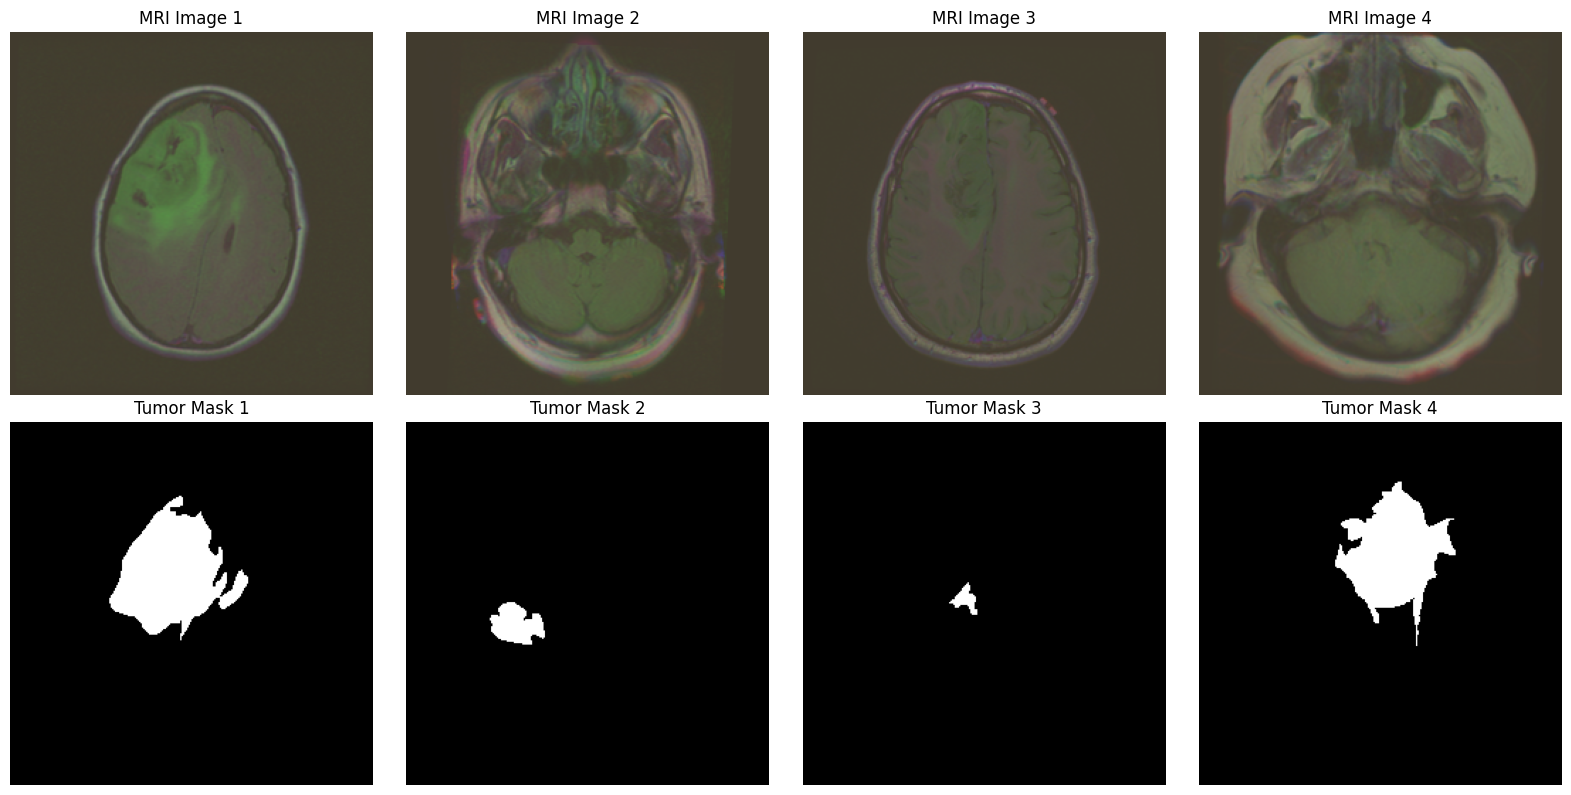

In [12]:
# Display 4 images with their masks side by side
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # TODO: Get an image-mask pair from train_dataset
    # Hint: Use train_dataset[i] to get the i-th sample

    # YOUR CODE HERE
    image, mask = train_dataset[i]

    # Display image (denormalize first)
    axes[0, i].imshow(denormalize(image))
    axes[0, i].set_title(f"MRI Image {i+1}")
    axes[0, i].axis("off")

    # Display mask
    axes[1, i].imshow(mask.squeeze(), cmap="gray")
    axes[1, i].set_title(f"Tumor Mask {i+1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

---

## **Task 5: Create the U-Net Model**

Use `segmentation_models_pytorch` to create a U-Net model with a pretrained encoder.

**Requirements:**
- Use a pretrained encoder backbone (e.g., ResNet34)
- Configure for binary segmentation (1 output class)
- Input: 3-channel RGB images

In [13]:
import segmentation_models_pytorch as smp

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
# YOUR CODE HERE
model = smp.Unet(encoder_name='resnet34', in_channels=3, classes=1)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

---

## **Task 6: Define Training and Validation Functions**

Implement the training and validation loops for the segmentation model.

**Requirements:**
- Training loop: forward pass, compute loss, backward pass, optimizer step
- Validation loop: forward pass, compute loss (no gradients)
- Use Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss)

In [15]:
import torch.optim as optim
from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device):
  model.train()
  total_loss = 0

  for images, masks in tqdm(dataloader):
    # Move data to device
    images, masks = images.to(device), masks.to(device).float()

    # TODO: Complete the training step
    # 1. Forward pass
    # 2. Compute loss
    # 3. Zero gradients
    # 4. Backward pass
    # 5. Update weights

    # YOUR CODE HERE
    outputs = model(images)
    loss = criterion(outputs, masks)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [16]:
# TODO: Task 6 (continued) - Complete the validation function

def validate(model, dataloader, criterion, device):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in dataloader:
      images, masks = images.to(device), masks.to(device).float()

      # TODO: Complete the validation step
      # 1. Forward pass
      # 2. Compute loss

      # YOUR CODE HERE
      outputs = model(images)
      loss = criterion(outputs, masks)

      total_loss += loss.item()

  return total_loss / len(dataloader)

---

## **Task 7: Train the Model**

Set up the loss function, optimizer, and run the training loop.

In [17]:
from torch import nn

# YOUR CODE HERE
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.001)

num_epochs = 10  # Train for 10 epochs

In [18]:
# Run training
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
  val_loss = validate(model, test_loader, criterion, device)

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

100%|██████████| 35/35 [00:22<00:00,  1.52it/s]


Epoch 1/10: Train Loss = 0.2983, Val Loss = 0.1710


100%|██████████| 35/35 [00:17<00:00,  2.03it/s]


Epoch 2/10: Train Loss = 0.1158, Val Loss = 0.1051


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 3/10: Train Loss = 0.0941, Val Loss = 0.0895


100%|██████████| 35/35 [00:17<00:00,  2.04it/s]


Epoch 4/10: Train Loss = 0.0842, Val Loss = 0.0970


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 5/10: Train Loss = 0.0788, Val Loss = 0.0871


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 6/10: Train Loss = 0.0761, Val Loss = 0.0807


100%|██████████| 35/35 [00:16<00:00,  2.08it/s]


Epoch 7/10: Train Loss = 0.0708, Val Loss = 0.0810


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 8/10: Train Loss = 0.0654, Val Loss = 0.0792


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 9/10: Train Loss = 0.0625, Val Loss = 0.0788


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 10/10: Train Loss = 0.0575, Val Loss = 0.0843


### **Plot Training Loss Curve**

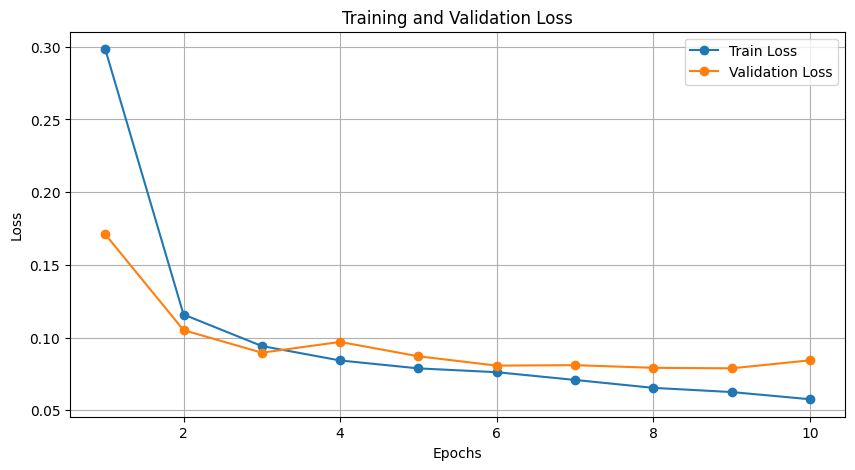

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

---

## **Task 8: Visualize Predictions**

Compare the model's predictions against the ground truth masks on test images.

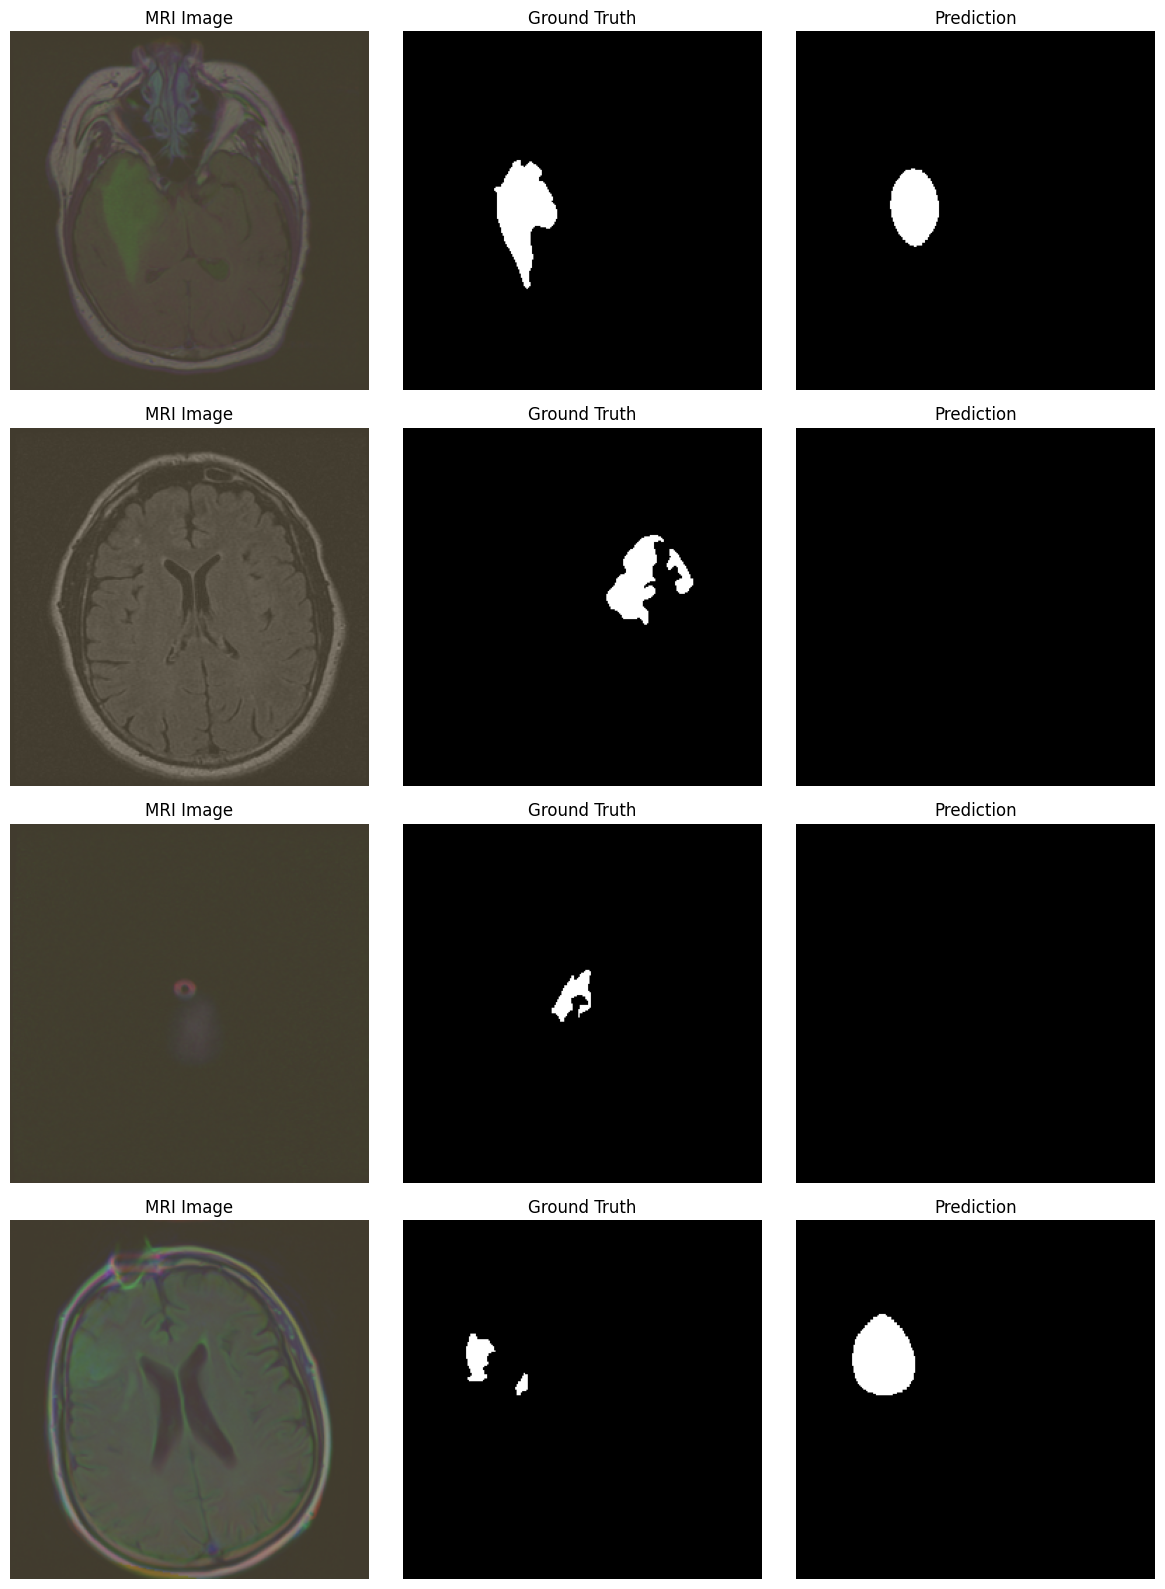

In [26]:
# TODO: Task 8 - Visualize predictions on test images
import random

model.eval()

fig, axes = plt.subplots(4, 3, figsize=(12, 16))

# Get random test samples
indices = random.sample(range(len(test_dataset)), 4)

for i, idx in enumerate(indices):
  image, mask = test_dataset[idx]

  # TODO: Get model prediction
  # 1. Add batch dimension: image.unsqueeze(0)
  # 2. Move to device
  # 3. Get prediction: model(image)
  # 4. Apply sigmoid to get probabilities
  # 5. Threshold at 0.5 to get binary mask

  with torch.no_grad():
    # YOUR CODE HERE
    pred = model(image.unsqueeze(0).to(device))  # Forward pass

    probs = torch.sigmoid(pred)


    pred = (probs > 0.5).cpu().float().numpy()

  # Display results
  axes[i, 0].imshow(denormalize(image))
  axes[i, 0].set_title("MRI Image")
  axes[i, 0].axis("off")

  axes[i, 1].imshow(mask.squeeze(), cmap="gray")
  axes[i, 1].set_title("Ground Truth")
  axes[i, 1].axis("off")

  axes[i, 2].imshow(pred.squeeze(), cmap="gray")
  axes[i, 2].set_title("Prediction")
  axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

---

### **Contributed by: Sattam Altwaim**